CARGAMOS LAS LIBRERIAS

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
import pydot
import graphviz
from sklearn.utils import resample

CARGAMOS EL DATASET QUE VAMOS A TRABAJAR

In [3]:
# Cargar el dataset
df = pd.read_excel("../data/interim/dimension-entorno-limpio.xlsx")
print("Total de datos:", len(df))
df.head()

Total de datos: 3538


,tipo,partido,radio10,sup_ha,pobl_tot,dens_ha,ind_trpu,ind_inunda,ind_evp,ind_cavas,...,Unnamed: 270,Unnamed: 271,Unnamed: 272,Unnamed: 273,Unnamed: 274,Unnamed: 275,Unnamed: 276,Unnamed: 277,Unnamed: 278,Unnamed: 279
0,URBANO,Almirante Brown,60283615,34.20,1816,53.10,0.86,1.0,0.444114,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,URBANO,Almirante Brown,60282701,18.62,658,35.34,0.99,1.0,1.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,URBANO,Almirante Brown,60283307,28.45,1499,52.69,1.00,1.0,0.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,URBANO,Almirante Brown,60282307,15.78,916,58.05,1.00,1.0,0.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,URBANO,Almirante Brown,60282603,24.27,919,37.87,0.96,1.0,1.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


GENERAMOS UN DATAFRAME CON LOS DATOS QUE VAMOS A UTILIZAR Y GUARDAMOS UNA COPIA EN GITHUB

In [4]:
# Seleccionar las columnas relevantes
columnas_relevantes = ['cat_ent', 'ind_trpu', 'ind_inunda', 'ind_evp', 'ind_cavas', 'ind_indus']
datos = df[columnas_relevantes]

# guardo el dataframe a utilizar en el modelo en el Git
datos.to_csv ("C:/Users/lenovo/Desktop/Git/INDICE-DE-ENTORNO-DE-CALIDAD-DE-VIDA/data/processed/datos.csv", index=False)
datos.head()

,cat_ent,ind_trpu,ind_inunda,ind_evp,ind_cavas,ind_indus
0,ALTO,0.86,1.0,0.444114,1.0,0.98
1,MEDIO,0.99,1.0,1.000000,1.0,0.20
2,ALTO,1.00,1.0,0.000000,1.0,1.00
3,MEDIO,1.00,1.0,0.000000,1.0,0.54
4,MEDIO,0.96,1.0,1.000000,1.0,0.13


DEFINIMOS LAS VARIABLES DE ESTUDIO

In [5]:
# Separar las características y la variable objetivo
X = datos[['ind_trpu', 'ind_inunda', 'ind_evp', 'ind_cavas', 'ind_indus']]
y = datos['cat_ent']

EXAMINAMOS LA DISTRIBUCION ORIGINAL DE DATOS POR CATEGORIAS

In [6]:
# Mostrar distribución original de las categorías
print("Distribución original de las categorías:")
print(y.value_counts())

Distribución original de las categorías:
cat_ent
MEDIO       1479
ALTO        1179
BAJO         490
MUY ALTO     304
MUY BAJO      86
Name: count, dtype: int64


GRAFICAMOS LA DISTRIBUCION ORIGINAL DE DATOS POR CATEGORIAS

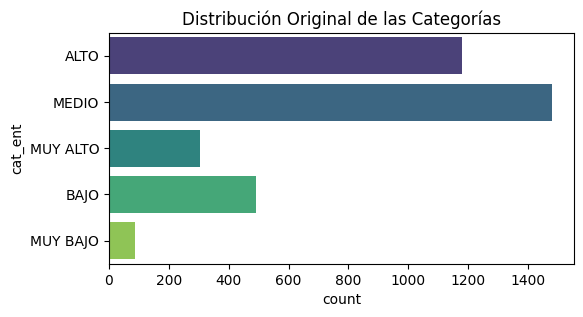

In [92]:
# Gráfico de distribución original ajustado para evitar la advertencia futura
plt.figure(figsize=(6, 3))
sns.countplot(y=y, hue=y, palette='viridis', legend=False)
plt.title('Distribución Original de las Categorías')
plt.show()

BALANCEAMOS LOS DATOS, LOS GUARDAMOS EN UN DTAFRAME, GUARDAMOS LOS DATOS EN GITHUB Y EXAMINAMOS LA DISTRIBUCION DE DATOS BALANCEADOS POR CATEGORIA

In [93]:
# Combinar características y la variable objetivo en un solo DataFrame
datos_completo = pd.concat([X, y], axis=1)

# Submuestreo para balancear las clases
clases = ['MEDIO', 'ALTO', 'BAJO', 'MUY ALTO', 'MUY BAJO']
datos_balanceados = pd.DataFrame()

for clase in clases:
    datos_clase = datos_completo[datos_completo['cat_ent'] == clase]
    datos_clase_submuestreados = resample(datos_clase, 
                                          replace=False,  # No hacer sobre muestreo
                                          n_samples=86,   # Número de muestras deseadas
                                          random_state=42)  # Asegura la reproducibilidad
    datos_balanceados = pd.concat([datos_balanceados, datos_clase_submuestreados])

# Mostrar la distribución de las clases en el nuevo DataFrame
print("Distribución balanceada de las categorías:")
print(datos_balanceados['cat_ent'].value_counts())

# Guardar el DataFrame balanceado en un archivo CSV
datos_balanceados.to_csv("C:/Users/lenovo/Desktop/Git/INDICE-DE-ENTORNO-DE-CALIDAD-DE-VIDA/data/processed/datos_balanceados_sin_datos_siteticos.csv", index=False)

Distribución balanceada de las categorías:
cat_ent
MEDIO       86
ALTO        86
BAJO        86
MUY ALTO    86
MUY BAJO    86
Name: count, dtype: int64


GRAFICAMOS LA DISTRIBUCION DE DATOS BALANCEADOS POR CATEGORIAS

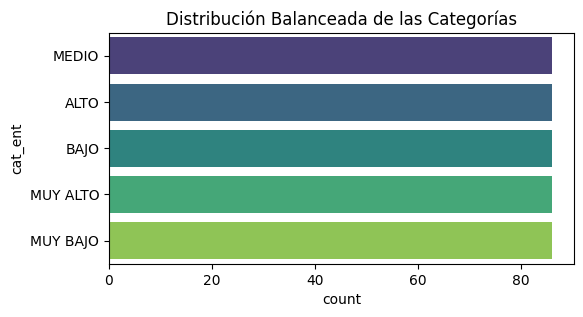

In [94]:
# Gráfico de distribución balanceada ajustado para evitar la advertencia futura
plt.figure(figsize=(6, 3))
sns.countplot(y=datos_balanceados['cat_ent'], hue=datos_balanceados['cat_ent'], palette='viridis', legend=False)
plt.title('Distribución Balanceada de las Categorías')
plt.show()

BUSCAMOS DATOS NULOS

In [95]:
# Buscar datos faltantes
datos_faltantes_por_columna = datos_balanceados.isnull().sum()
datos_faltantes_totales = datos_balanceados.isnull().sum().sum()
print("Datos faltantes por columna:")
print(datos_faltantes_por_columna)
print("\nTotal de datos faltantes:", datos_faltantes_totales)

Datos faltantes por columna:
ind_trpu      0
ind_inunda    0
ind_evp       0
ind_cavas     0
ind_indus     0
cat_ent       0
dtype: int64

Total de datos faltantes: 0


NORMALIZAMOS LOS DATOS

In [96]:
# Normalizar los datos
scaler = StandardScaler()
datos_numericos = datos_balanceados.select_dtypes(include=['float64', 'int64'])
datos_normalizados = scaler.fit_transform(datos_numericos)
datos_normalizados = pd.DataFrame(datos_normalizados, columns=datos_numericos.columns)

DIVIDIMOS EL SET DE DATOS EN DATOS DE PRUEBA Y ENTRENAMIENTO

In [97]:
# Dividir los datos normalizados en conjuntos de entrenamiento y prueba
X = datos_normalizados[['ind_trpu', 'ind_inunda', 'ind_evp', 'ind_cavas', 'ind_indus']]
y = datos_balanceados['cat_ent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **A CONTINUACION SE REALIZARAN 3 MODELOS PREDICTIVOS DE APRENDIZAJE AUTOMATICO**

### **1_RANDOM FOREST**

GENERAMOS MODELO RANDOM FOREST

In [98]:
# Entrenamiento del modelo
# Seleccionar y entrenar el modelo (usando Random Forest en este caso)
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

REALIZAMOS LAS PREDICCIONES

In [99]:
# Realizar predicciones sobre el conjunto de prueba
y_pred_rf = modelo_rf.predict(X_test)

COMPARAMOS LAS PREDICCIONES CON LOS DATOS DE PRUEBA

In [100]:
# Mostrar las predicciones junto con la precisión de cada predicción
resultados = pd.DataFrame({'Dato de Prueba': y_test, 'Dato Predecido': y_pred_rf})
resultados['Precision'] = resultados['Dato de Prueba'] == resultados['Dato Predecido']
print("Resultados del conjunto de prueba:")
print(resultados)

Resultados del conjunto de prueba:
     Dato de Prueba Dato Predecido  Precision
731        MUY BAJO       MUY BAJO       True
3247          MEDIO          MEDIO       True
1843           BAJO           BAJO       True
3154          MEDIO           BAJO      False
2437       MUY BAJO       MUY BAJO       True
...             ...            ...        ...
370        MUY BAJO       MUY BAJO       True
1682          MEDIO          MEDIO       True
1018           ALTO           ALTO       True
1109          MEDIO          MEDIO       True
726           MEDIO          MEDIO       True

[86 rows x 3 columns]


VERIFICAMOS LA PPRECISION DEL MODELO

In [101]:
# Realizar predicciones sobre el conjunto de prueba
y_pred_rf = modelo_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)
print("\nRandom Forest - Accuracy en el conjunto de prueba:", accuracy_rf)
print("Classification Report en el conjunto de prueba:\n", classification_rep_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)


Random Forest - Accuracy en el conjunto de prueba: 0.7906976744186046
Classification Report en el conjunto de prueba:
               precision    recall  f1-score   support

        ALTO       0.75      0.80      0.77        15
        BAJO       0.55      0.86      0.67        14
       MEDIO       0.89      0.68      0.77        25
    MUY ALTO       1.00      0.93      0.96        14
    MUY BAJO       0.88      0.78      0.82        18

    accuracy                           0.79        86
   macro avg       0.81      0.81      0.80        86
weighted avg       0.83      0.79      0.80        86



VISUALIZAMOS LA PRECISION DEL MODELO A TRAVEZ DE UNA MATRIZ DE CONFUSION

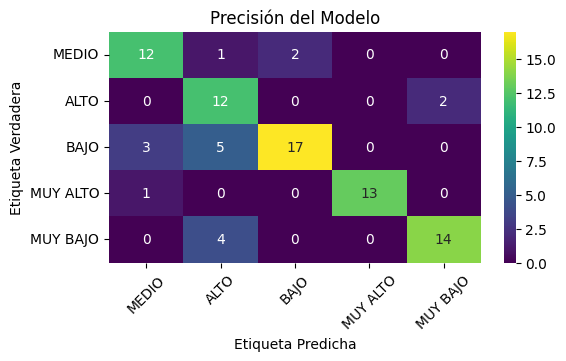

In [102]:
# Matriz de Confusión
categories = y.unique()
conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')

# Etiquetar los ejes con los valores de la variable dependiente
plt.xticks(ticks=np.arange(len(categories)) + 0.5, labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)) + 0.5, labels=categories, rotation=0)
plt.title('Precisión del Modelo')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()

MOSTRAMOS LA INCIDENCIA DE CADA VARIABLE EN EL MODELO

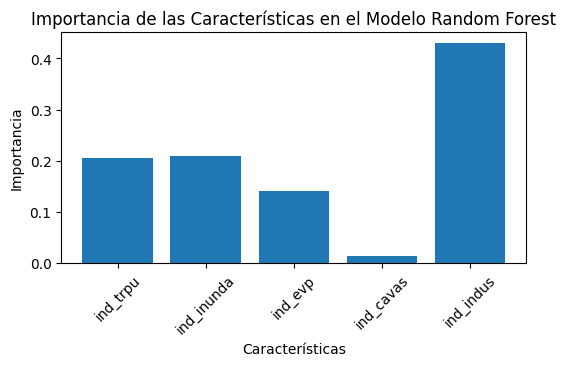

In [103]:
# Visualización de la importancia de las características en el modelo Random Forest
plt.figure(figsize=(6, 3))
plt.bar(X.columns, modelo_rf.feature_importances_)
plt.title('Importancia de las Características en el Modelo Random Forest')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.xticks(rotation=45)
plt.show()

### **2_ARBOL DE DECISION**

GENERMOS UN MODELO DE ARBOL DE DECISION

In [104]:
# Modelo 2: Árbol de Decisión
modelo_arbol = DecisionTreeClassifier(random_state=42)
modelo_arbol.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

VISUALIZMOS EL ARBOL DE DECISION

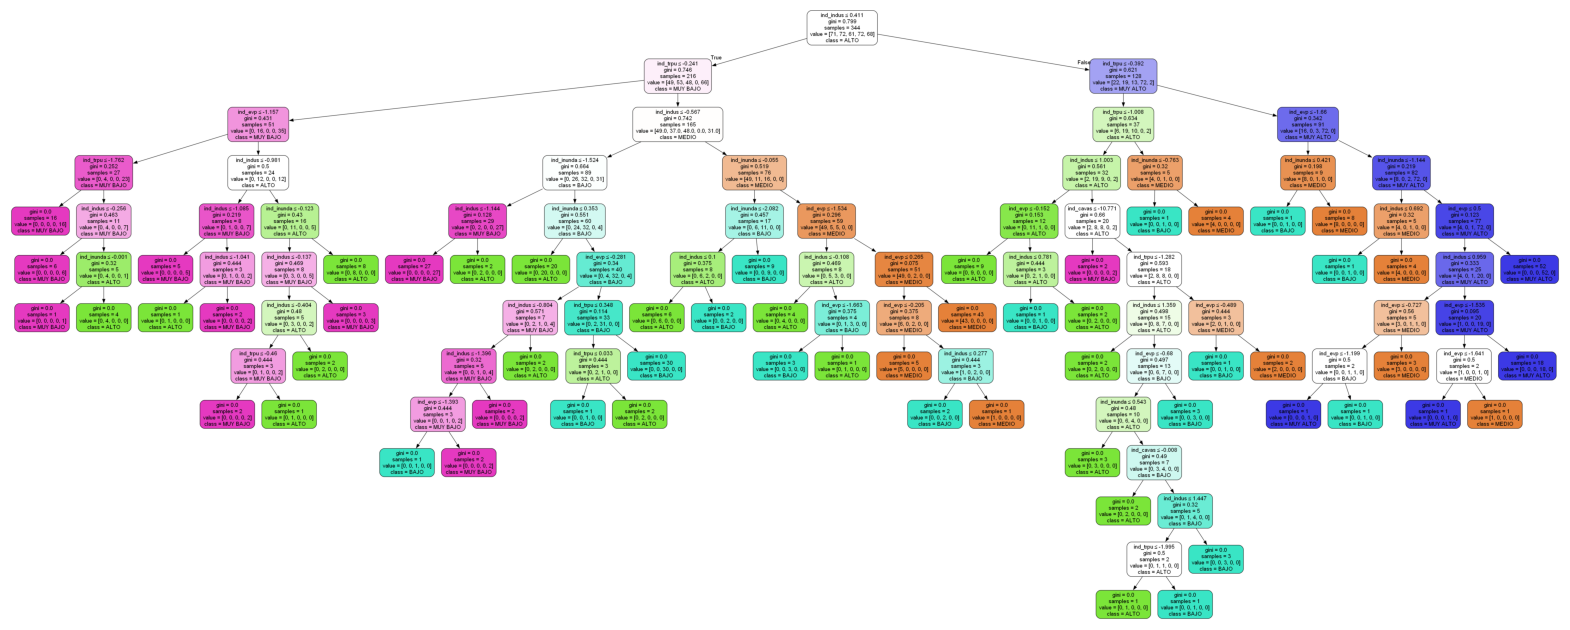

In [105]:
# Leer el archivo .dot y visualizar el árbol de decisión
export_graphviz(modelo_arbol, out_file='arbol_decision_sin_datos_sintetcos.dot', feature_names=X.columns, class_names=y.unique(), filled=True, rounded=True, special_characters=True)
with open("arbol_decision_sin_datos_sintetcos.dot") as f:
    dot_graph = f.read() 
graph = graphviz.Source(dot_graph)
graph.render(filename='arbol_decision_sin_datos_sintetcos', format='png', cleanup=True)

# Ajustar el tamaño de la figura antes de mostrarla
plt.figure(figsize=(20, 20))  # Ajusta el tamaño según sea necesario
img = plt.imread('arbol_decision_sin_datos_sintetcos.png')
plt.imshow(img)
plt.axis('off')  # Desactivar los ejes
plt.show()
#graph

EXPORTAMOS LA IMAGEN DEL ARBOL DE DECISION A GITHUB

In [106]:
# Exportar el árbol de decisión a un archivo .dot en un directorio específico de GitHub
export_graphviz(modelo_arbol, out_file="arbol_decision_sin datos_sinteticos.dot", feature_names=X.columns, class_names=modelo_arbol.classes_, filled=True)

# Leer el archivo .dot y convertirlo a .png
(graph,) = pydot.graph_from_dot_file("arbol_decision_sin_datos_sintetcos.dot")
graph.write_png("C:/Users/lenovo/Desktop/Git/INDICE-DE-ENTORNO-DE-CALIDAD-DE-VIDA/reports/figures/arbol_decision_sin_datos_sinteticos.png")

GENERAMOS LAS PREDICCIONES

In [107]:
# Evaluar el rendimiento del modelo
# Realizar predicciones sobre el conjunto de prueba
y_pred_test = modelo_arbol.predict(X_test)

COMPARAMOS LAS PREDICCIONES CON LOS DATOS DE PRUEBA

In [108]:
# Mostrar las predicciones junto con la precisión de cada predicción
resultados_arbol = pd.DataFrame({'Dato de Prueba': y_test, 'Dato Predecido': y_pred_test})
resultados_arbol['Precision'] = resultados_arbol['Dato de Prueba'] == resultados_arbol['Dato Predecido']
print("Resultados del conjunto de prueba (Árbol de Decisión):")
print(resultados_arbol)

Resultados del conjunto de prueba (Árbol de Decisión):
     Dato de Prueba Dato Predecido  Precision
731        MUY BAJO       MUY BAJO       True
3247          MEDIO          MEDIO       True
1843           BAJO           BAJO       True
3154          MEDIO           BAJO      False
2437       MUY BAJO       MUY BAJO       True
...             ...            ...        ...
370        MUY BAJO       MUY BAJO       True
1682          MEDIO          MEDIO       True
1018           ALTO           ALTO       True
1109          MEDIO          MEDIO       True
726           MEDIO          MEDIO       True

[86 rows x 3 columns]


EVALUAMOS LA PRECISION DEL MODELO

In [109]:
# Calcular y mostrar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy en el conjunto de prueba: {accuracy:.4f}")

# Generar y mostrar el reporte de clasificación
classification_rep = classification_report(y_test, y_pred_test)
print("Classification Report en el conjunto de prueba:\n", classification_rep)

Accuracy en el conjunto de prueba: 0.7442
Classification Report en el conjunto de prueba:
               precision    recall  f1-score   support

        ALTO       0.67      0.67      0.67        15
        BAJO       0.50      0.79      0.61        14
       MEDIO       0.84      0.64      0.73        25
    MUY ALTO       1.00      0.93      0.96        14
    MUY BAJO       0.82      0.78      0.80        18

    accuracy                           0.74        86
   macro avg       0.77      0.76      0.75        86
weighted avg       0.78      0.74      0.75        86



VISUALIZAMOS LA PRECISION DEL MODELO A TRAVEZ DE UNA MATRIZ DE CONFUSION

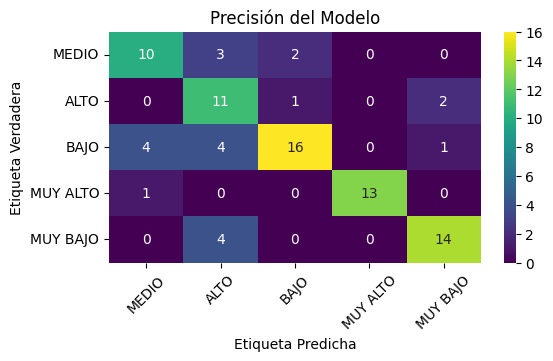

In [110]:
# Generar y mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')

# Etiquetar los ejes con los valores de la variable dependiente
plt.xticks(ticks=np.arange(len(categories)) + 0.5, labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)) + 0.5, labels=categories, rotation=0)
plt.title('Precisión del Modelo')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()

VISUALIZAMOS LA INCIDENCIA DE CADA VARIABLE EN EL MODELO

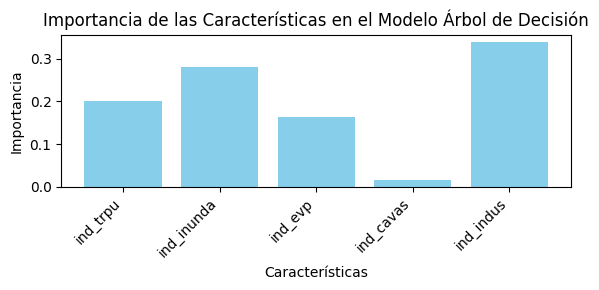

In [111]:
# Visualización de la importancia de las características en el modelo Árbol de Decisión
plt.figure(figsize=(6, 3))
plt.bar(X.columns, modelo_arbol.feature_importances_, color='skyblue')
plt.title('Importancia de las Características en el Modelo Árbol de Decisión')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### **3_REGRESION LOGISTICA**

GENERAMOS UN MODELO DE REGRESION LOGISTICA

In [112]:
# Modelo 3: Regresión Logística
modelo_lr = LogisticRegression(max_iter=1000, random_state=42)
modelo_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

REALIZAMOS LAS PREDICCIONES

In [113]:
# Realizar predicciones sobre el conjunto de prueba
y_pred_lr = modelo_lr.predict(X_test)

COMPARAMOS LAS PREDICCIONES CON LOS DATOS DE PRUEBA

In [114]:
# Mostrar las predicciones junto con la precisión de cada predicción
resultados = pd.DataFrame({'Dato de Prueba': y_test, 'Dato Predecido': y_pred_test})
resultados['Presicion'] = resultados['Dato de Prueba'] == resultados['Dato Predecido']
print("Resultados del conjunto de prueba:")
print(resultados)

Resultados del conjunto de prueba:
     Dato de Prueba Dato Predecido  Presicion
731        MUY BAJO       MUY BAJO       True
3247          MEDIO          MEDIO       True
1843           BAJO           BAJO       True
3154          MEDIO           BAJO      False
2437       MUY BAJO       MUY BAJO       True
...             ...            ...        ...
370        MUY BAJO       MUY BAJO       True
1682          MEDIO          MEDIO       True
1018           ALTO           ALTO       True
1109          MEDIO          MEDIO       True
726           MEDIO          MEDIO       True

[86 rows x 3 columns]


VERIFICAMOS LA PRECISION DEL MODELO

In [115]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
classification_rep_lr = classification_report(y_test, y_pred_lr)
print("\nRegresión Logística - Accuracy en el conjunto de prueba:", accuracy_lr)
print("Classification Report en el conjunto de prueba:\n", classification_rep_lr)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)


Regresión Logística - Accuracy en el conjunto de prueba: 0.7906976744186046
Classification Report en el conjunto de prueba:
               precision    recall  f1-score   support

        ALTO       0.59      0.87      0.70        15
        BAJO       0.68      0.93      0.79        14
       MEDIO       1.00      0.52      0.68        25
    MUY ALTO       0.92      0.79      0.85        14
    MUY BAJO       0.90      1.00      0.95        18

    accuracy                           0.79        86
   macro avg       0.82      0.82      0.79        86
weighted avg       0.84      0.79      0.79        86



VISUALIZAMOS LA PRECISION DEL MODELO A TRAVEZ DE UNA MATRIZ DE CONFUSION

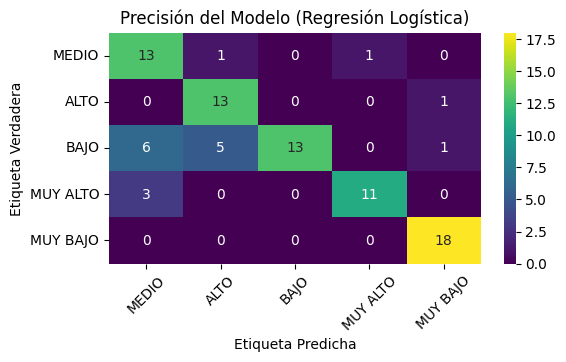

In [116]:
# Matriz de Confusión
categories = y.unique()
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 3))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='viridis')
# Etiquetar los ejes con los valores de la variable dependiente
plt.xticks(ticks=np.arange(len(categories)) + 0.5, labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)) + 0.5, labels=categories, rotation=0)
plt.title('Precisión del Modelo (Regresión Logística)')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()

VISUALIZAMOS LA INCIDENCIA DE CADA VARIABLE EN EL MODELO

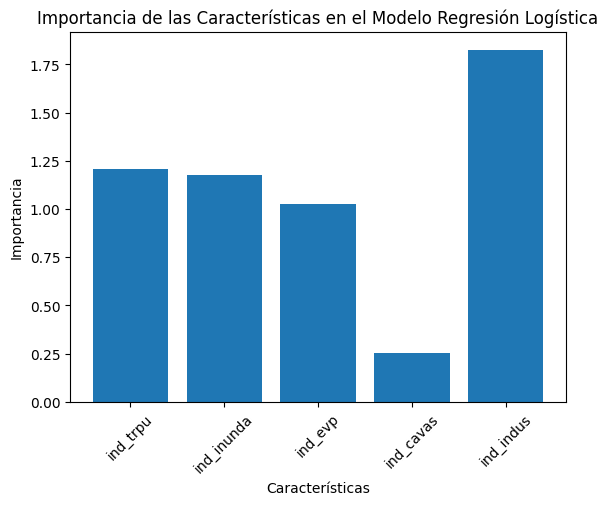

In [117]:
# Visualización de la importancia de las características en el modelo Regresión Logística
plt.figure()
plt.bar(X.columns, modelo_lr.coef_[0])
plt.title('Importancia de las Características en el Modelo Regresión Logística')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.xticks(rotation=45)
plt.show()

### **COMPARACION DE PERFORMANCE DE LOS MODELOS RANDON FOREST, ARBOL DE DECISION Y REGRESION LOGISTICA**

COMPARAMOS LA PRESICION DE LOS TRES MODELOS

In [118]:
# Calculando precisiones para los modelos Random Forest y Regresión Logística (ya calculados previamente)

# Modelo 2: Árbol de Decisión
modelo_arbol = DecisionTreeClassifier(random_state=42)
modelo_arbol.fit(X_train, y_train)
y_pred_arbol = modelo_arbol.predict(X_test)
accuracy_arbol = accuracy_score(y_test, y_pred_arbol)

# Comparación de los resultados de los tres modelos
resultados_comparacion = pd.DataFrame({
    'Modelo': ['Random Forest', 'Árbol de Decisión', 'Regresión Logística'],
    'Accuracy': [accuracy_rf, accuracy_arbol, accuracy_lr]
})
print("\nComparación de los resultados de los tres modelos:")
print(resultados_comparacion)



Comparación de los resultados de los tres modelos:
                Modelo  Accuracy
0        Random Forest  0.790698
1    Árbol de Decisión  0.744186
2  Regresión Logística  0.790698


VISUALIZAMOS LA PPRECISION DE LOS TRES MODELOS A TRAVEZ DE SU MATRIZ DE CONFUSION

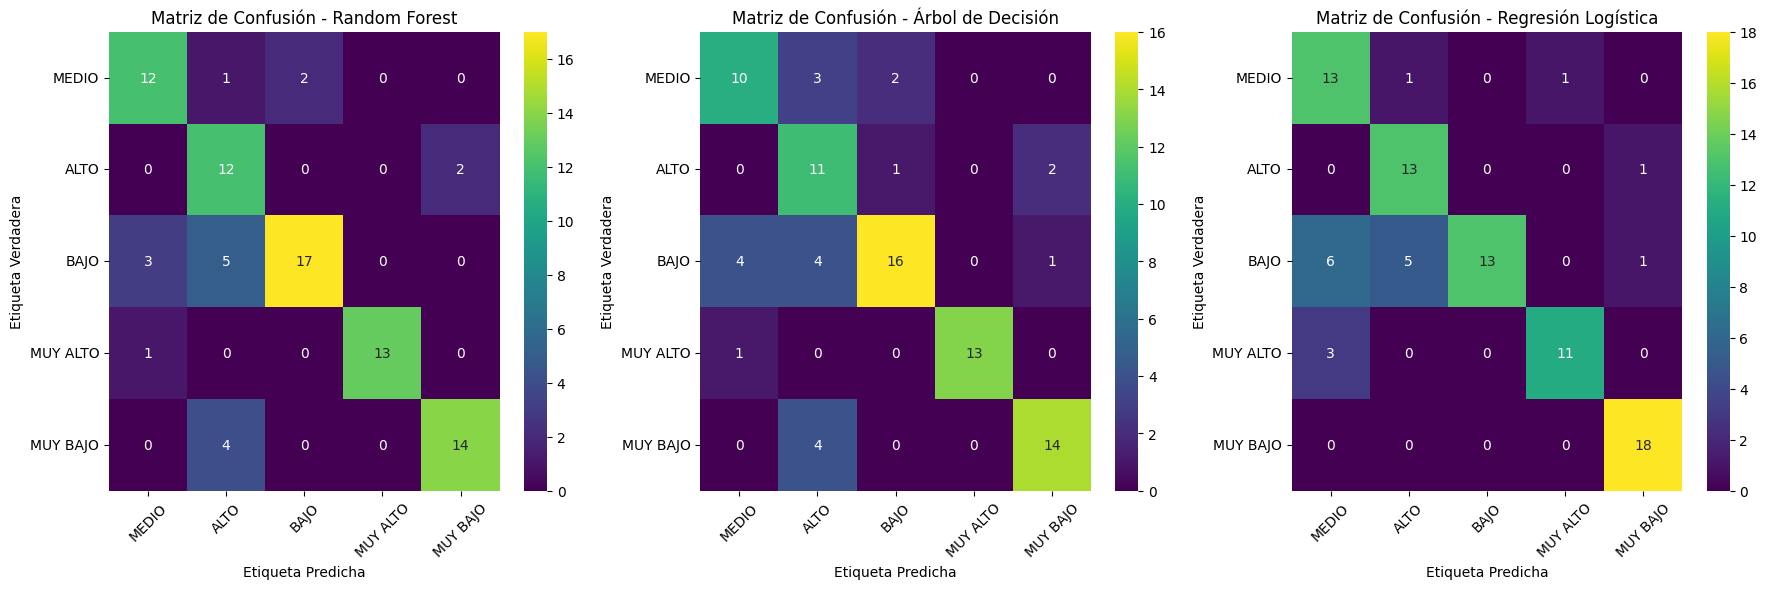

In [119]:
# Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Árbol de Decisión
conf_matrix_arbol = confusion_matrix(y_test, y_pred_arbol)

# Regresión Logística (asumiendo que ya tienes y_pred_lr)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Gráficos de matriz de confusión para cada modelo
plt.figure(figsize=(18, 6))

# Random Forest
plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='viridis')
plt.xticks(ticks=np.arange(len(categories)) + 0.5, labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)) + 0.5, labels=categories, rotation=0)
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')

# Árbol de Decisión
plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_arbol, annot=True, fmt='d', cmap='viridis')
plt.xticks(ticks=np.arange(len(categories)) + 0.5, labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)) + 0.5, labels=categories, rotation=0)
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')

# Regresión Logística
plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='viridis')
plt.xticks(ticks=np.arange(len(categories)) + 0.5, labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)) + 0.5, labels=categories, rotation=0)
plt.title('Matriz de Confusión - Regresión Logística')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')

plt.tight_layout()
plt.show()